In [1]:
import numpy as np
import os, glob
import matplotlib.pyplot as plt

import h5py
import sys
sys.path.append('../')
import analysis_utils as utils

yale_colors = ['#00356b', '#286dc0', '#63aaff', '#4a4a4a']
utils.load_plotting_setting()

In [2]:
import importlib
importlib.reload(utils)

<module 'analysis_utils' from '/Users/yuhan/work/nanospheres/impulse_analysis/analysis_notebooks/../analysis_utils.py'>

In [3]:
from datetime import datetime

def plot_rates(sphere, dataset, data_prefix, n_file, bc, rates, ax=None):
    dir = rf'/Volumes/LaCie/dm_data/{sphere}/{dataset}'
    file = os.path.join(dir, f'{data_prefix}0.hdf5')
    f = h5py.File(file, 'r')
    start_time = str(datetime.fromtimestamp(f['data'].attrs['timestamp']))
    f.close()

    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 5))

    ax.plot(bc, rates[0], '-', color=yale_colors[0], label='All', alpha=1)
    ax.plot(bc, rates[1], '-', color=yale_colors[1], label='Detection quality cut', alpha=1)
    ax.plot(bc, rates[2], '-', color=yale_colors[2], label='Detection quality + noise cut', alpha=1)
    ax.plot(bc, rates[3], '-', color=yale_colors[3], label='Detection quality + noise + anti-coincidence cut', alpha=1)

    # ax.legend(frameon=False, fontsize=12)

    ax.set_yscale('log')
    ax.set_xlim(0, 10000)
    ax.set_ylim(1e-8, 500)

    # ax.set_xlabel('Recon. amplitude (keV)')
    # ax.set_ylabel('Differential count (Hz/keV)')
    # ax.set_title(f'Data ({n_file/60:.1f} hours), begins {start_time}')

In [4]:
sphere = 'sphere_20241221'
datasets = ['20241221_3e-7mbar_16e_alignment0_long'
           ]

data_prefixs = ['20241221_d_',
                ]

n_files = [1331]

bc, scaling = None, None
hhs, rates, n_windows = [], [], []
for i, dataset in enumerate(datasets):
    data_dir = f'/Users/yuhan/work/nanospheres/data/dm_data_processed/{sphere}/{dataset}'
    
    _bc, _hhs, _rates, _n, _scaling = utils.get_summed_rates(data_dir, dataset)
    hhs.append(_hhs)
    rates.append(_rates)
    n_windows.append(_n)

    if bc is None:
        bc = _bc
    if scaling is None:
        scaling = _scaling


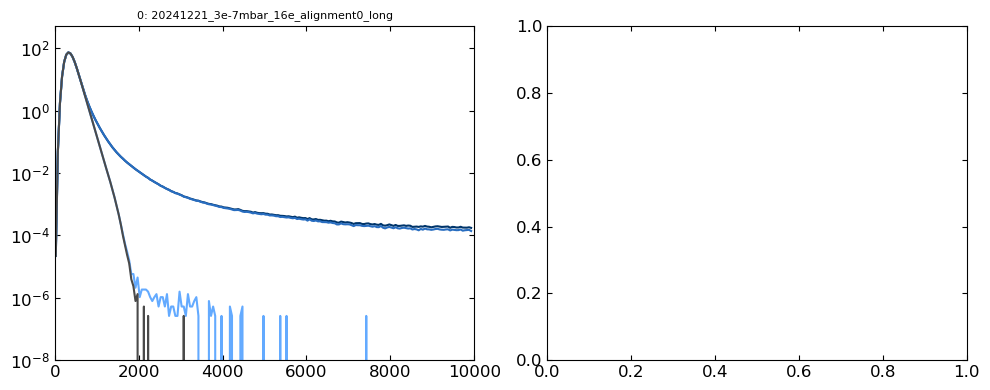

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

for i in range(len(datasets)):
    ax = axes.flatten()[i]
    plot_rates(sphere, datasets[i], data_prefixs[i], n_files[i], bc, rates[i], ax)
    ax.set_title(f'{i}: {datasets[i]}', fontsize=8)

axes[0]
fig.tight_layout()

Text(0, 0.5, 'Differential count (Hz/keV)')

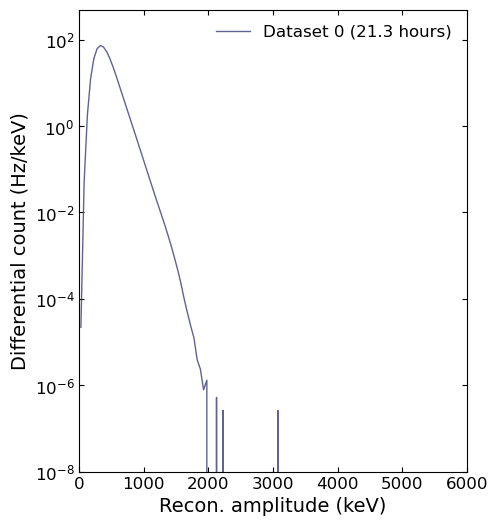

In [6]:
colors = plt.colormaps.get_cmap('tab20b').resampled(len(datasets)).colors
fig, ax = plt.subplots(figsize=(5, 6))

n_search_per_win = (5000 - 150) / 25
time_per_search = 2e-6 * 25
scaling = n_search_per_win * time_per_search * 50  # because of the 50 keV bins

times = [n[-1] * n_search_per_win * time_per_search / 3600 for n in n_windows] # Time in hours for each dataset (aftercut)

for i in range(len(datasets)):
    ax.plot(bc, rates[i][-1], '-', color=colors[i], label=f'Dataset {i} ({times[i]:.1f} hours)', alpha=0.8, linewidth=1)

ax.legend(frameon=False, fontsize=12)

ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_xlim(0, 6000)
ax.set_ylim(1e-8, 500)

ax.set_xlabel('Recon. amplitude (keV)')
ax.set_ylabel('Differential count (Hz/keV)')

<>:22: SyntaxWarning: invalid escape sequence '\s'
<>:22: SyntaxWarning: invalid escape sequence '\s'
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_32061/2918724953.py:22: SyntaxWarning: invalid escape sequence '\s'
  ax.plot(xx, utils.gauss(xx, gaus_amp/(popt[0] * np.sqrt(2*np.pi)), 0, popt[0]), '--', color='#DC3220', label=f'$\sigma$ = {popt[0]:.1f} keV/c')


Text(0, 0.5, 'Differential count (Hz/keV/c)')

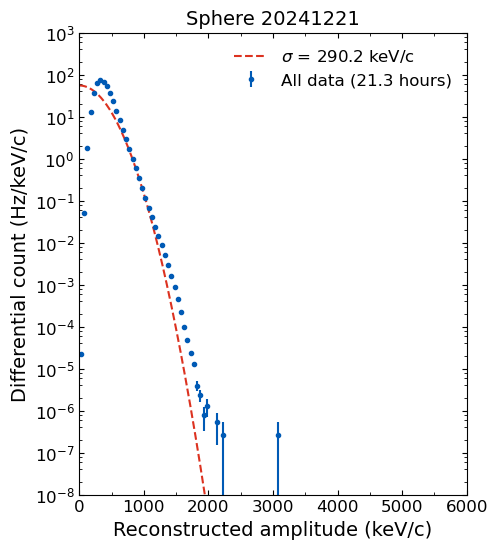

In [7]:
hh_sum = np.sum(np.asarray(hhs), axis=0)
n_window_sum = np.sum(np.asarray(n_windows), axis=0)
time_sum = np.sum(np.asarray(times))

from matplotlib.ticker import LogLocator, NullFormatter, MultipleLocator
from scipy.optimize import curve_fit

fig, ax = plt.subplots(figsize=(5, 6))
ax.errorbar(bc, hh_sum[3] / (n_window_sum[3] * scaling), yerr=np.sqrt(hh_sum[3])/(n_window_sum[3]*scaling), fmt='.', color='#005AB5', label=f'All data ({time_sum:.1f} hours)', alpha=1)

# Factor of 2 because we only have half of a Gaussian
gaus_amp = 2 * 1 / (2e-6 * 25)  # (1 s)/(time per search)
sigma = 282

fit_lb, fit_ub = 900, 2000
idx_fit = np.logical_and(bc > fit_lb, bc < fit_ub)
popt, pcov = curve_fit(lambda x, b: utils.gauss(x, gaus_amp/(sigma * np.sqrt(2*np.pi)), 0, b), 
                       bc[idx_fit], (hh_sum[3]/(n_window_sum[3] * scaling))[idx_fit], p0=[280])

xx = np.linspace(0, 3000, 500)
# ax.plot(xx, utils.gauss(xx, gaus_amp/(sigma * np.sqrt(2*np.pi)), 0, sigma), '--', color='#DC3220', label=f'$\sigma$ = {sigma} keV/c')
ax.plot(xx, utils.gauss(xx, gaus_amp/(popt[0] * np.sqrt(2*np.pi)), 0, popt[0]), '--', color='#DC3220', label=f'$\sigma$ = {popt[0]:.1f} keV/c')

ax.legend(frameon=False, fontsize=12)

ax.set_yscale('log')
# ax.set_xscale('log')

ax.set_xlim(0, 6000)
ax.set_ylim(1e-8, 1000)

ax.set_yticks(np.logspace(-8, 3, 12))
locmin = LogLocator(base=10.0, subs=(0.2, 0.4, 0.6, 0.8), numticks=15)
ax.xaxis.set_minor_locator(MultipleLocator(500))
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(NullFormatter())

ax.set_title('Sphere 20241221')
ax.set_xlabel('Reconstructed amplitude (keV/c)')
ax.set_ylabel('Differential count (Hz/keV/c)')

In [8]:
data_dir = f'/Users/yuhan/work/nanospheres/data/dm_data_processed/{sphere}/{datasets[0]}'
data_prefix = r'20241221_d_'

hists_0 = utils.load_data_hists(data_dir, data_prefix, n_files[0], 1600)

events_after_cut_0 = utils.get_events_after_cut(hists_0, thr=2000)
print('Number of windows with large events: ', len(events_after_cut_0))

Number of windows with large events:  4


/Volumes/LaCie/dm_data/sphere_20241221/20241221_3e-7mbar_16e_alignment0_long/20241221_d_178.hdf5
/Volumes/LaCie/dm_data/sphere_20241221/20241221_3e-7mbar_16e_alignment0_long/20241221_d_569.hdf5
/Volumes/LaCie/dm_data/sphere_20241221/20241221_3e-7mbar_16e_alignment0_long/20241221_d_785.hdf5
/Volumes/LaCie/dm_data/sphere_20241221/20241221_3e-7mbar_16e_alignment0_long/20241221_d_786.hdf5


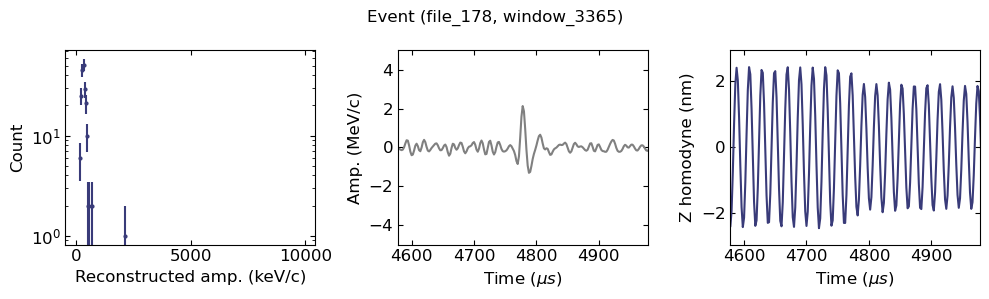

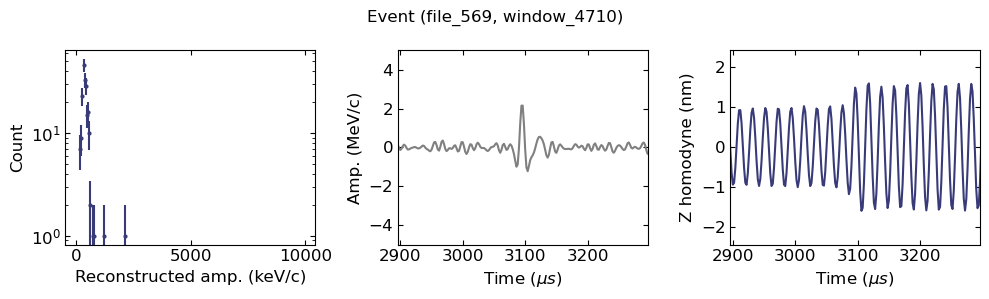

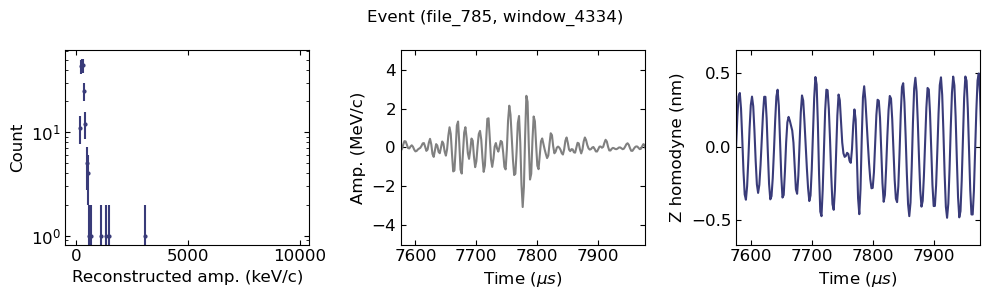

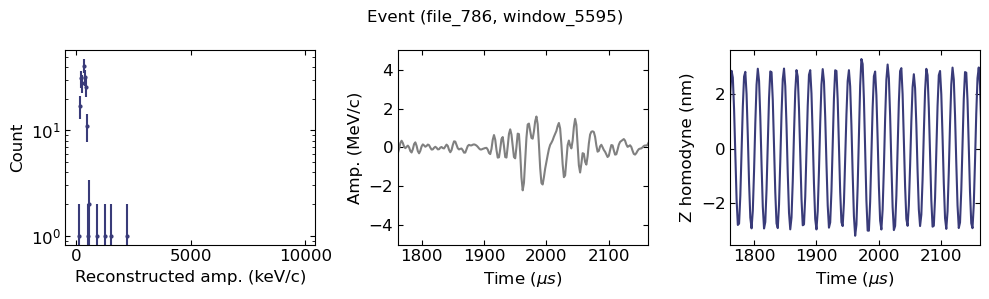

In [9]:
raw_data_dir = rf'/Volumes/LaCie/dm_data/{sphere}/{datasets[0]}'

c_mv = 5.522e-08
amp2kev = 6844.611961407297

window_length = 5000
bins = np.arange(0, 10000, 50)
bc = 0.5 * (bins[:-1] + bins[1:])

for i, j in events_after_cut_0[:]:
    _, _, _, _, _, _ = utils.plot_hist_events(raw_data_dir, data_prefix, i, j, window_length, bins, bc, c_mv, amp2kev, False, True)